### Training model

- Decide which feature to use(just try first)
- Split training data to training data set and validation data set
- Select serval models to train
- Generate submission file (change column name 'date' back to 'day' before submission)


### Feature explanation

- year, year of data
- month, month of year 
- day, day of month
- hour, hour of day from 0 ~ 23
- weekday, week of day from 0 to 6, 0 is Mon, 1 is Tue, 2 is Wed etc.
- grid_id, grid id defined in grid info
- temperture, temperture at given time
- rainy, 0 means no rain, 1 means is rainy
- holiday, 0 means working day, 1 means holiday
- car_number, number of cars in that grid at given time

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import timeit
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
%matplotlib inline


training_features_filepath = 'data/training.csv'
test_features_filepath = 'data/test.csv'
submission_filepath = 'data/submit_samples.csv'
lgb_submission_filepath = 'data/submission_lgb.csv'
xgb_submission_filepath = 'data/submission_xgb.csv'
ann_submission_filepath = 'data/submission_ann.csv'
final_submission_filepath = 'data/submission_final.csv'

training_features_xgb_filepath = 'data/training_xgb.csv'
test_features_xgb_filepath = 'data/test_xgb.csv'

training_features_lgb_filepath = 'data/training_lgb.csv'
test_features_lgb_filepath = 'data/test_lgb.csv'

drop_columns = ['car_number','year', 'rainy','holiday']

one_hot_encoding_columns = ['weekday','grid_id']

# loading data
train = pd.read_csv(training_features_filepath)
#train = pd.get_dummies(train, columns=one_hot_encoding_columns)
train.head()

,year,month,day,hour,weekday,grid_id,temperture,rainy,holiday,car_number
0,2017,1,2,9,0,51,13,0,1,14.0
1,2017,1,2,9,0,52,13,0,1,0.0
2,2017,1,2,9,0,53,13,0,1,4.0
3,2017,1,2,9,0,54,13,0,1,4.0
4,2017,1,2,9,0,55,13,0,1,6.0


In [2]:
test = pd.read_csv(test_features_filepath)
#test = pd.get_dummies(test, columns=one_hot_encoding_columns)
test.head()

,year,month,day,hour,weekday,grid_id,temperture,rainy,holiday,car_number
0,2017,3,13,9,0,51,9,1,0,0
1,2017,3,13,9,0,52,9,1,0,0
2,2017,3,13,9,0,53,9,1,0,0
3,2017,3,13,9,0,54,9,1,0,0
4,2017,3,13,9,0,55,9,1,0,0


In [3]:
def retrieve_index_by_month_day_hour(df, month, day, hour):
    month = df[df['month'] == month]
    day = month[month['day'] == day]
    hour = day[day['hour'] == hour]
    return hour.index[0]

def generate_submission_file(pred, output_filepath):
    sample_df = pd.read_csv(submission_filepath)
    sample_df['car_number'] = pred
    #sample_df['car_number'] = sample_df['car_number'].apply(lambda x : np.ceil(x))
    #sample_df['car_number'] = sample_df['car_number'].astype(int)
    sample_df.columns = ['grid_id','day','hour','car_number']
    sample_df.to_csv(output_filepath, index=False)

def split_train_val_data(index, train):
    # split train and val by index
    train_ = train.iloc[:index]
    val_ = train.iloc[index:-1]
    # extract x and y
    train_x = train_.drop(columns=drop_columns)
    train_y = train_['car_number']
    val_x = val_.drop(columns=drop_columns)
    val_y = val_['car_number']
    return train_x, train_y, val_x, val_y

def val_or_generate_submission_file_xgb(param_dict, train, test, index, t='train'):
    regressor = xgb.XGBRegressor(**param_dict)        
    # only train and validate
    if t == 'train':
        # train with part of data
        train_x, train_y, val_x, val_y = split_train_val_data(index, train)
        regressor.fit(train_x.as_matrix(), train_y)
        pred = regressor.predict(val_x.as_matrix())
        print("score is ", np.sqrt(mean_squared_error(val_y, pred)))
        return regressor
    # using predition as a extra feature
    elif t == 'extract':
        train_x = train.drop(columns=drop_columns)
        train_y = train['car_number']
        regressor.fit(train_x.as_matrix(), train_y)
        test_ = test.drop(columns=drop_columns)
        pred = regressor.predict(test_.as_matrix())
        # extract new feature to test
        test['xgb'] = np.ceil(pred)
        test.to_csv(test_features_xgb_filepath, index=False)
        # extract new feature to train
        pred = regressor.predict(train_x.as_matrix())
        train['xgb'] = np.ceil(pred)
        train.to_csv(training_features_xgb_filepath, index=False)        
    # using the whole data set to train and do prediction
    else:
        print("Train with all the data and generate submission file")
        # train with all the data
        train_x = train.drop(columns=drop_columns)
        train_y = train['car_number']
        regressor.fit(train_x.as_matrix(), train_y)
        test_ = test.drop(columns=drop_columns)
        pred = regressor.predict(test_.as_matrix())
        generate_submission_file(pred, xgb_submission_filepath)
    return regressor
        
        
def val_or_generate_submission_file_lgbm(param_dict, n_estimators, train, test, index, t='train'):
    # only train and validate
    if t == 'train':
        # train with part of data
        train_x, train_y, val_x, val_y = split_train_val_data(index, train)
        d_train = lgb.Dataset(train_x, label=train_y)
        d_valid = lgb.Dataset(val_x, label=val_y)
        watchlist = [d_valid]    
        model = lgb.train(param_dict, d_train, n_estimators, watchlist, verbose_eval=0)
        pred = model.predict(val_x)
        print("score is ", np.sqrt(mean_squared_error(val_y, pred)))
        return model
    # using predition as a extra feature
    elif t == 'extract':
        train_x = train.drop(columns=drop_columns)
        train_y = train['car_number']
        d_train = lgb.Dataset(train_x, label=train_y)
        model = lgb.train(param_dict, d_train, n_estimators, verbose_eval=0)
        test_ = test.drop(columns=drop_columns)
        # extract predition to test
        pred = model.predict(test_)
        test['lgb'] = np.ceil(pred)
        test.to_csv(test_features_lgb_filepath, index=False)
        # extract prediction to train
        pred = model.predict(train_x)
        train['lgb'] = np.ceil(pred)
        train.to_csv(training_features_lgb_filepath, index=False)
        return model
    # using the whole data set to train and do prediction
    else:
        print("Train with all the data and generate submission file")
        # train with all the data
        train_x = train.drop(columns=drop_columns)
        train_y = train['car_number']
        d_train = lgb.Dataset(train_x, label=train_y)
        model = lgb.train(param_dict, d_train, n_estimators, verbose_eval=0)
        test_ = test.drop(columns=drop_columns)
        pred = model.predict(test_)
        generate_submission_file(pred, lgb_submission_filepath)
        return model
        
def plot_model(history):
    train_loss = history.history['loss']
    #train_acc = history.history['acc']
    val_loss = history.history['val_loss']
    #val_acc = history.history['val_acc']

    niter = np.arange(len(train_loss))

    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

    ax1.plot(niter, train_loss, label='train')
    ax1.plot(niter, val_loss, label='validation')
    ax1.set_title("loss")
    ax1.set_xlabel('ecphos')
    ax1.set_ylabel('loss')
    #ax1.set_ylim(0, 100)

    #ax2.plot(niter, train_acc, label='train')
    #ax2.plot(niter, val_acc, label='validation')
    #ax2.set_title("accuracy")
    #ax2.set_xlabel('ecphos')
    #ax2.set_ylabel('accuracy')
    #ax2.set_ylim(0.85, 1)

    plt.legend()
    plt.show()
    

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

### TODOs

- Try use ceil instead of round. **Done test score : 8.0536**
- Try remove wind and visibitly and make a submission. **Done test score : 8.0266**
- Add average speed as grid feature and make a submission **Done test socre: 8.058**
- Add missing data and set car number to average via ceil **Done test socre: 8.0373**
- Add missing data and set car number to average via round **Done test socre: 8.0484**
- Try LGB and make a submission **Done test socre: 8.0091**
- Try filter invalid date in each csv and make a submission via LGB **Done test socre: 8.0012**
- Adding avg,std,median car number to features and make a submission via LGB **Done test socre: 8.1684**
- Remove outliers and make a submission via LGB **Done test socre: 8.0288**
- Try NN or LSTM and make a submission (2018-09-xx)
- Try ensemble learning and stacking models (2018-09-xx)
- Plot 50 grids on map and see if can find more features for grid (2018-09-xx)


### XGB Model 1 - Extract feature

In [41]:
param_dict = {
    'max_depth' : 5,
    'learning_rate' : 0.01,
    'n_estimators' : 1500,
    'silent' : True,
    'objective' : 'reg:linear',
    'booster' : 'gbtree',
    'n_jobs' : 8,
    'gamma' : 0,
    'min_child_weight' : 1,
    'max_delta_step' : 0,
    'subsample' : 0.75,
    'colsample_bytree' : 0.9,
    'reg_alpha' : 0.7,
    'reg_lambda' : 1
}
index = retrieve_index_by_month_day_hour(train, 3, 6, 9)
val_or_generate_submission_file_xgb(param_dict, train, test, index, 'extract')
#val_or_generate_submission_file_xgb(param_dict, train, test, index)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=8, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.7, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

### Light GBM Model 1 - Extract feature

In [42]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'n_jobs': 8,
    'metric': 'rmse',
    'max_depth': 5,
    'learning_rate': 0.01,
    'verbose': 0}

n_estimators = 4750
# reloading data
train = pd.read_csv(training_features_xgb_filepath)
test = pd.read_csv(test_features_xgb_filepath)
index = retrieve_index_by_month_day_hour(train, 3, 6, 9)
val_or_generate_submission_file_lgbm(params, n_estimators, train, test, index, 'extract')
#val_or_generate_submission_file_lgbm(params, n_estimators, train, test, index)

### XGB Model 2 - Prediction

In [18]:
param_dict = {
    'max_depth' : 9,
    'learning_rate' : 0.01,
    'n_estimators' : 1500,
    'silent' : True,
    'objective' : 'reg:linear',
    'booster' : 'gbtree',
    'n_jobs' : 8,
    'gamma' : 0,
    'min_child_weight' : 1,
    'max_delta_step' : 0,
    'subsample' : 0.75,
    'colsample_bytree' : 0.9,
    'reg_alpha' : 0.7,
    'reg_lambda' : 1
}
# loading train and test set with xgb and lgb features
#train = pd.read_csv(training_features_lgb_filepath) 3.9324405404334053
#test = pd.read_csv(test_features_lgb_filepath)
# predict
index = retrieve_index_by_month_day_hour(train, 3, 6, 9)
xgb_model = val_or_generate_submission_file_xgb(param_dict, train, test, index, 'trai') # 3.7814815857930983 3.7791889254407973

Train with all the data and generate submission file


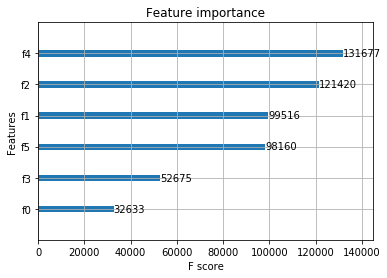

In [5]:
plot_importance(xgb_model)

### Light GBM Model 2 - Prediction

In [19]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'n_jobs': 8,
    'metric': 'rmse',
    'max_depth': 7,
    'num_leaves': 100,
    'learning_rate': 0.01,
    'verbose': 0}

n_estimators = 4750
# loading train and test set with xgb and lgb features
#train = pd.read_csv(training_features_lgb_filepath)
#test = pd.read_csv(test_features_lgb_filepath)
# prediction
index = retrieve_index_by_month_day_hour(train, 3, 6, 9)
lgb_model = val_or_generate_submission_file_lgbm(params, n_estimators, train, test, index,'trai') # 3.745223024590602

Train with all the data and generate submission file


### ANN Model

In [55]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Embedding
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler

# loading train and test data set
train = pd.read_csv(training_features_lgb_filepath)
test = pd.read_csv(test_features_lgb_filepath)

# retrieve val index
val_idx = retrieve_index_by_month_day_hour(train, 3, 6, 9)

# retrieve length of train data for later use
train_idx = train.shape[0]

# retrieve target
train_y = train['car_number']

# drop uncessary columns
train = train.drop(columns=drop_columns)
test = test.drop(columns=drop_columns)

# merging train and test
data = train.append(test)

# one hot encoding
data = pd.get_dummies(data, columns=one_hot_encoding_columns)

# normalization
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)

# split train and test
train_x = data[:train_idx]
test_x = data[train_idx:]

# split train and val
#train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# split data by val_idx, using last week as validation data
train_x, val_x, train_y, val_y = train_x[:val_idx], train_x[val_idx:], train_y[:val_idx], train_y[val_idx:]

# adam
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = Sequential()
model.add(Dense(256, input_shape=(train_x.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               16384     
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_30 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 117,249
Trainable params: 116,225
Non-trainable params: 1,024
_________________________________________________________________


In [52]:
# fit data
history = model.fit(train_x, train_y, epochs=20, batch_size=1024, validation_data=(val_x, val_y), verbose=1)

Train on 39200 samples, validate on 4900 samples
Epoch 1/20
39200/39200 [==============================] - 1s 24us/step - loss: 103.3977 - val_loss: 61.8250
Epoch 2/20
39200/39200 [==============================] - 0s 8us/step - loss: 13.9901 - val_loss: 23.1443
Epoch 3/20
39200/39200 [==============================] - 0s 8us/step - loss: 12.4080 - val_loss: 14.0887
Epoch 4/20
39200/39200 [==============================] - 0s 8us/step - loss: 11.9978 - val_loss: 13.1592
Epoch 5/20
39200/39200 [==============================] - 0s 8us/step - loss: 11.7167 - val_loss: 13.5904
Epoch 6/20
39200/39200 [==============================] - 0s 7us/step - loss: 11.5688 - val_loss: 13.2232
Epoch 7/20
39200/39200 [==============================] - 0s 7us/step - loss: 11.3348 - val_loss: 11.9864
Epoch 8/20
39200/39200 [==============================] - 0s 7us/step - loss: 11.1928 - val_loss: 12.2048
Epoch 9/20
39200/39200 [==============================] - 0s 7us/step - loss: 11.1177 - val_loss: 13.

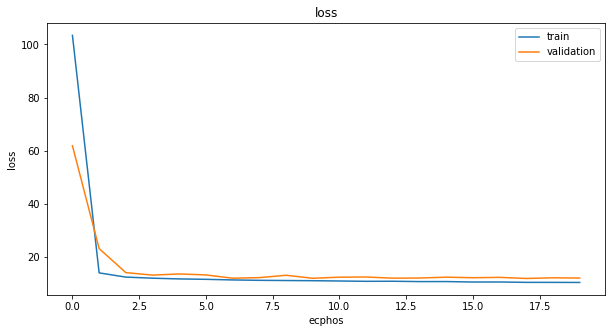

In [53]:
plot_model(history)

In [56]:
# fit the whole data set
model.fit(train_x, train_y, epochs=20, batch_size=1024, verbose=1)

Epoch 1/20
39200/39200 [==============================] - 1s 24us/step - loss: 81.2678
Epoch 2/20
39200/39200 [==============================] - 0s 6us/step - loss: 13.9940
Epoch 3/20
39200/39200 [==============================] - 0s 8us/step - loss: 12.4615
Epoch 4/20
39200/39200 [==============================] - 0s 6us/step - loss: 12.0650
Epoch 5/20
39200/39200 [==============================] - 0s 7us/step - loss: 11.7856
Epoch 6/20
39200/39200 [==============================] - 0s 8us/step - loss: 11.4482
Epoch 7/20
39200/39200 [==============================] - 0s 7us/step - loss: 11.2911
Epoch 8/20
39200/39200 [==============================] - 0s 6us/step - loss: 11.1581
Epoch 9/20
39200/39200 [==============================] - 0s 7us/step - loss: 11.0319
Epoch 10/20
39200/39200 [==============================] - 0s 6us/step - loss: 10.9211
Epoch 11/20
39200/39200 [==============================] - 0s 7us/step - loss: 10.8260
Epoch 12/20
39200/39200 [==========================

In [57]:
# predit and generate submission file
pred = model.predict(test_x)
generate_submission_file(pred, ann_submission_filepath)

### Averaging prediction

In [20]:
# def averaging_prediction(xgb, lgb, ann):
#     if (xgb < 0):
#         xgb = 0
#     if (lgb < 0):
#         lgb = 0
#     if (ann < 0):
#         ann = 0
#     car_number = xgb * 0.25 + lgb * 0.25 + ann * 0.5
#     return np.ceil(car_number)

def averaging_prediction(xgb, lgb):
    if (xgb < 0):
        xgb = 0
    if (lgb < 0):
        lgb = 0
    car_number = (xgb + lgb) / 2
    return np.ceil(car_number)
    
# loading prediction file
xgb_pred = pd.read_csv(xgb_submission_filepath)
lgb_pred = pd.read_csv(lgb_submission_filepath)
#nn_pred = pd.read_csv(ann_submission_filepath)
# rename car_number
xgb_pred = xgb_pred.rename(columns={'car_number': 'car_number_xgb'})
lgb_pred = lgb_pred.rename(columns={'car_number': 'car_number_lgb'})
#nn_pred = nn_pred.rename(columns={'car_number': 'car_number_ann'})
# merge all the dataframes
avg_sub = pd.merge(xgb_pred, lgb_pred, on=['grid_id','day','hour'], how='left')
#avg_sub = pd.merge(avg_sub, nn_pred, on=['grid_id','day','hour'], how='left')
avg_sub['car_number'] = 0
avg_sub['car_number'] = avg_sub.apply(lambda row: averaging_prediction(row['car_number_xgb'], row['car_number_lgb']), axis=1)
avg_sub = avg_sub.drop(columns=['car_number_xgb', 'car_number_lgb'])
# set all the grid 52 result to 0
grid_52_idx = avg_sub.grid_id == 52
avg_sub.loc[grid_52_idx, 'car_number'] = 0
avg_sub.to_csv(final_submission_filepath, index=False)

### LSTM Model (TODO)

In [56]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

train_grid_id_1 = train[train['grid_id']==1]
train_grid_id_1 = train_grid_id_1.reset_index()
index = retrieve_index_by_month_day_hour(train_grid_id_1, 3, 6, 9)
train_x, train_y, val_x, val_y = split_train_val_data(index, train_grid_id_1)

train_x = train_x.drop(columns=['grid_id'])
val_x = val_x.drop(columns=['grid_id'])

min_max_scaler = MinMaxScaler()
train_x = min_max_scaler.fit_transform(train_x)
val_x = min_max_scaler.fit_transform(val_x)

train_x = np.reshape(train_x, (1, 784, 8))
val_x = np.reshape(val_x, (1, 97, 8))

lstm = Sequential()
lstm.add(LSTM(20, dropout=0.1, recurrent_dropout=0.1, input_shape=(784, 8), return_sequences=True))
lstm.add(LSTM(10, dropout=0.1, recurrent_dropout=0.1))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

lstm.summary()

#lstm.fit(train_x, train_y, epochs=100, batch_size=1, validation_data=(val_x, val_y), verbose=1)
#score, mse = lstm.evaluate(val_x, val_y, batch_size=1)
#print(score + ", " + mse)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 784, 20)           2320      
_________________________________________________________________
lstm_22 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 3,571
Trainable params: 3,571
Non-trainable params: 0
_________________________________________________________________
